In [18]:
import pandas as pd

df = pd.read_csv('data/data_full.csv')
print(df.shape)
df.head(2)

(985, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
0,0.0,0.0,0.0,212,13.326,1,96,844,1689,2127,13266,20250731
1,0.9,0.5,0.6,212,13.911,1,100,19888,35221,30901,65535,20250731


In [19]:
df['date'].value_counts()

date
20250729    110
20251029     75
20251030     75
20251101     75
20251102     75
20251103     75
20251106     75
20251108     66
20250731     56
20250801     52
20251028     51
20251031     50
20251104     50
20251105     50
20251107     50
Name: count, dtype: int64

## Split data

In [20]:
df_train = df[(df['date'] != 20251105) &
              (df['date'] != 20251106) &
              (df['date'] != 20251107) &
              (df['date'] != 20251108)]
print(df_train.shape)
df_train.head(2)

(744, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
0,0.0,0.0,0.0,212,13.326,1,96,844,1689,2127,13266,20250731
1,0.9,0.5,0.6,212,13.911,1,100,19888,35221,30901,65535,20250731


In [21]:
df_test = df[~((df['date'] != 20251105) &
               (df['date'] != 20251106) &
               (df['date'] != 20251107) &
               (df['date'] != 20251108))]
print(df_test.shape)
df_test.head(2)

(241, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
744,0.5,0.5,0.5,309,7.339,1,21,15646,32848,16225,52768,20251105
745,0.4,0.2,0.7,309,7.341,1,21,21620,13780,13176,42881,20251105


In [22]:
# Save split data

if True:
    df_train.to_csv('data_split/data_train.csv', index=False)
    df_test.to_csv('data_split/data_test.csv', index=False)

## Meta-learning

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [24]:
# Split tasks

X_cols = ['R', 'G', 'B']
Y_cols = ['I_445', 'I_515', 'I_630', 'I_clear']

grouped_by_date = df_train.groupby('date')

tasks = []
for day, df_day in grouped_by_date:
    X_day = df_day[X_cols].to_numpy()
    Y_day = df_day[Y_cols].to_numpy()
    if len(X_day) < 10:
        continue
    tasks.append((day, X_day, Y_day))

print(f"Total days (tasks): {len(tasks)}")

Total days (tasks): 11


In [25]:
# Scale data

X_all = df_train[X_cols].to_numpy()
Y_all = df_train[Y_cols].to_numpy()

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_all_scaled = X_scaler.fit_transform(X_all)
Y_all_scaled = Y_scaler.fit_transform(Y_all)

tasks_scaled = []
for day, _, _ in tasks:
    mask = df_train['date'] == day
    X_day = X_all_scaled[mask.to_numpy()]
    Y_day = Y_all_scaled[mask.to_numpy()]
    tasks_scaled.append((day, X_day, Y_day))

In [26]:
# Meta-learning config and loop

np.random.seed(0)
input_dim = len(X_cols)
output_dim = len(Y_cols)
k_shot = 10
meta_lr = 0.001
inner_lr = 0.005
meta_iters = 1000

W_meta = np.random.randn(output_dim, input_dim) * 0.01
b_meta = np.zeros(output_dim)

for meta_iter in range(meta_iters):
    dW_meta = np.zeros_like(W_meta)
    db_meta = np.zeros_like(b_meta)
    
    for day, X_day, Y_day in tasks_scaled:
        n = len(X_day)
        if n < k_shot * 2:
            continue  # skip days with too few samples
        
        # Randomly sample train/val split within this day
        idx = np.random.permutation(n)
        idx_train = idx[:k_shot]
        idx_val = idx[k_shot:2*k_shot]
        
        X_train, Y_train = X_day[idx_train], Y_day[idx_train]
        X_val, Y_val = X_day[idx_val], Y_day[idx_val]
        
        # Inner adaptation
        Y_pred = X_train @ W_meta.T + b_meta
        grad_W = (2 / k_shot) * (Y_pred - Y_train).T @ X_train
        grad_b = (2 / k_shot) * np.sum(Y_pred - Y_train, axis=0)
        W_task = W_meta - inner_lr * grad_W
        b_task = b_meta - inner_lr * grad_b
        
        # Outer evaluation
        Y_val_pred = X_val @ W_task.T + b_task
        grad_W_meta = (2 / k_shot) * (Y_val_pred - Y_val).T @ X_val
        grad_b_meta = (2 / k_shot) * np.sum(Y_val_pred - Y_val, axis=0)
        
        dW_meta += grad_W_meta
        db_meta += grad_b_meta
    
    # Meta-update
    W_meta -= meta_lr * dW_meta / len(tasks_scaled)
    b_meta -= meta_lr * db_meta / len(tasks_scaled)
    
    if meta_iter % 50 == 0:
        loss_meta = np.mean((Y_val_pred - Y_val)**2)
        print(f"Iter {meta_iter:03d} | Meta-loss: {loss_meta:.6f}")

Iter 000 | Meta-loss: 1.130947
Iter 050 | Meta-loss: 0.721820
Iter 100 | Meta-loss: 0.694957
Iter 150 | Meta-loss: 0.461869
Iter 200 | Meta-loss: 0.543081
Iter 250 | Meta-loss: 0.385699
Iter 300 | Meta-loss: 0.390420
Iter 350 | Meta-loss: 0.170899
Iter 400 | Meta-loss: 0.260307
Iter 450 | Meta-loss: 0.183954
Iter 500 | Meta-loss: 0.144731
Iter 550 | Meta-loss: 0.215665
Iter 600 | Meta-loss: 0.106207
Iter 650 | Meta-loss: 0.130967
Iter 700 | Meta-loss: 0.114616
Iter 750 | Meta-loss: 0.083411
Iter 800 | Meta-loss: 0.052674
Iter 850 | Meta-loss: 0.066676
Iter 900 | Meta-loss: 0.059298
Iter 950 | Meta-loss: 0.053586


In [27]:
print("W_meta: ", W_meta)
print("b_meta: ", b_meta)

W_meta:  [[0.02184909 0.01649219 0.85713216]
 [0.03251946 0.85960696 0.01020435]
 [0.84601318 0.0570642  0.03230557]
 [0.28886575 0.58873204 0.34496645]]
b_meta:  [0.0149261  0.01057958 0.01538082 0.02668661]


## Predition

In [28]:
np.random.seed(42)
k_shot = 10        
inner_lr = 0.05

test_days = sorted(df_test['date'].unique())

results = []

for day_target in test_days:
    df_target = df_test[df_test['date'] == day_target]
    if len(df_target) < 10:
        continue  # skip very small days

    X_target = df_target[X_cols].to_numpy()
    Y_target = df_target[Y_cols].to_numpy()
    X_target_scaled = X_scaler.transform(X_target)
    Y_target_scaled = Y_scaler.transform(Y_target)

    # Split into few-shot
    nT = len(X_target_scaled)
    # k = min(k_shot, nT // 2)
    k = 10
    idx = np.random.choice(nT, size=k, replace=False)
    mask = np.ones(nT, dtype=bool)
    mask[idx] = False
    X_adapt, Y_adapt = X_target_scaled[idx], Y_target_scaled[idx]
    X_eval,  Y_eval  = X_target_scaled[mask], Y_target_scaled[mask]

    # BEFORE ADAPTATION
    Y_pred_before_scaled = X_eval @ W_meta.T + b_meta
    Y_pred_before = Y_scaler.inverse_transform(Y_pred_before_scaled)
    Y_eval_orig   = Y_scaler.inverse_transform(Y_eval)

    r2_before = [r2_score(Y_eval_orig[:, i], Y_pred_before[:, i]) for i in range(len(Y_cols))]

    # AFTER ADAPTATION
    Y_pred_adapt = X_adapt @ W_meta.T + b_meta
    grad_W = (2 / len(X_adapt)) * (Y_pred_adapt - Y_adapt).T @ X_adapt
    grad_b = (2 / len(X_adapt)) * np.sum(Y_pred_adapt - Y_adapt, axis=0)
    W_adapt = W_meta - inner_lr * grad_W
    b_adapt = b_meta - inner_lr * grad_b

    Y_pred_after_scaled = X_eval @ W_adapt.T + b_adapt
    Y_pred_after = Y_scaler.inverse_transform(Y_pred_after_scaled)

    r2_after = [r2_score(Y_eval_orig[:, i], Y_pred_after[:, i]) for i in range(len(Y_cols))]

    results.append({
        'day': day_target,
        'r2_before': r2_before,
        'r2_after': r2_after,
    })

    print(f"\nDay {day_target} | samples={nT} | few-shot={k}")
    print("R2 before:", dict(zip(Y_cols, np.round(r2_before, 3))))
    print("R2 after :", dict(zip(Y_cols, np.round(r2_after, 3))))

# Average R2 across all test days per channel
r2_before_all = np.array([r['r2_before'] for r in results])
r2_after_all  = np.array([r['r2_after']  for r in results])

avg_r2_before = np.mean(r2_before_all, axis=0)
avg_r2_after  = np.mean(r2_after_all, axis=0)

print("\n=============================")
print("Average per-channel R2 before adaptation:")
print(dict(zip(Y_cols, np.round(avg_r2_before, 3))))
print("\nAverage per-channel R2 after adaptation:")
print(dict(zip(Y_cols, np.round(avg_r2_after, 3))))


Day 20251105 | samples=50 | few-shot=10
R2 before: {'I_445': 0.98, 'I_515': 0.979, 'I_630': 0.96, 'I_clear': 0.852}
R2 after : {'I_445': 0.982, 'I_515': 0.982, 'I_630': 0.966, 'I_clear': 0.876}

Day 20251106 | samples=75 | few-shot=10
R2 before: {'I_445': 0.979, 'I_515': 0.976, 'I_630': 0.959, 'I_clear': 0.802}
R2 after : {'I_445': 0.982, 'I_515': 0.981, 'I_630': 0.965, 'I_clear': 0.804}

Day 20251107 | samples=50 | few-shot=10
R2 before: {'I_445': 0.979, 'I_515': 0.98, 'I_630': 0.977, 'I_clear': 0.893}
R2 after : {'I_445': 0.985, 'I_515': 0.984, 'I_630': 0.979, 'I_clear': 0.901}

Day 20251108 | samples=66 | few-shot=10
R2 before: {'I_445': 0.978, 'I_515': 0.981, 'I_630': 0.976, 'I_clear': 0.83}
R2 after : {'I_445': 0.982, 'I_515': 0.984, 'I_630': 0.978, 'I_clear': 0.83}

Average per-channel R2 before adaptation:
{'I_445': 0.979, 'I_515': 0.979, 'I_630': 0.968, 'I_clear': 0.844}

Average per-channel R2 after adaptation:
{'I_445': 0.983, 'I_515': 0.983, 'I_630': 0.972, 'I_clear': 0.853

In [29]:
print("Latest adapt: ")
print("W_adapt: ", W_adapt)
print("b_adapt: ", b_adapt)

Latest adapt: 
W_adapt:  [[0.02256442 0.01735747 0.87144741]
 [0.03346495 0.87782446 0.01226002]
 [0.85604712 0.05782272 0.03494787]
 [0.29226792 0.6012862  0.33969559]]
b_adapt:  [0.01093989 0.01794547 0.01788144 0.02862566]


## Vis results

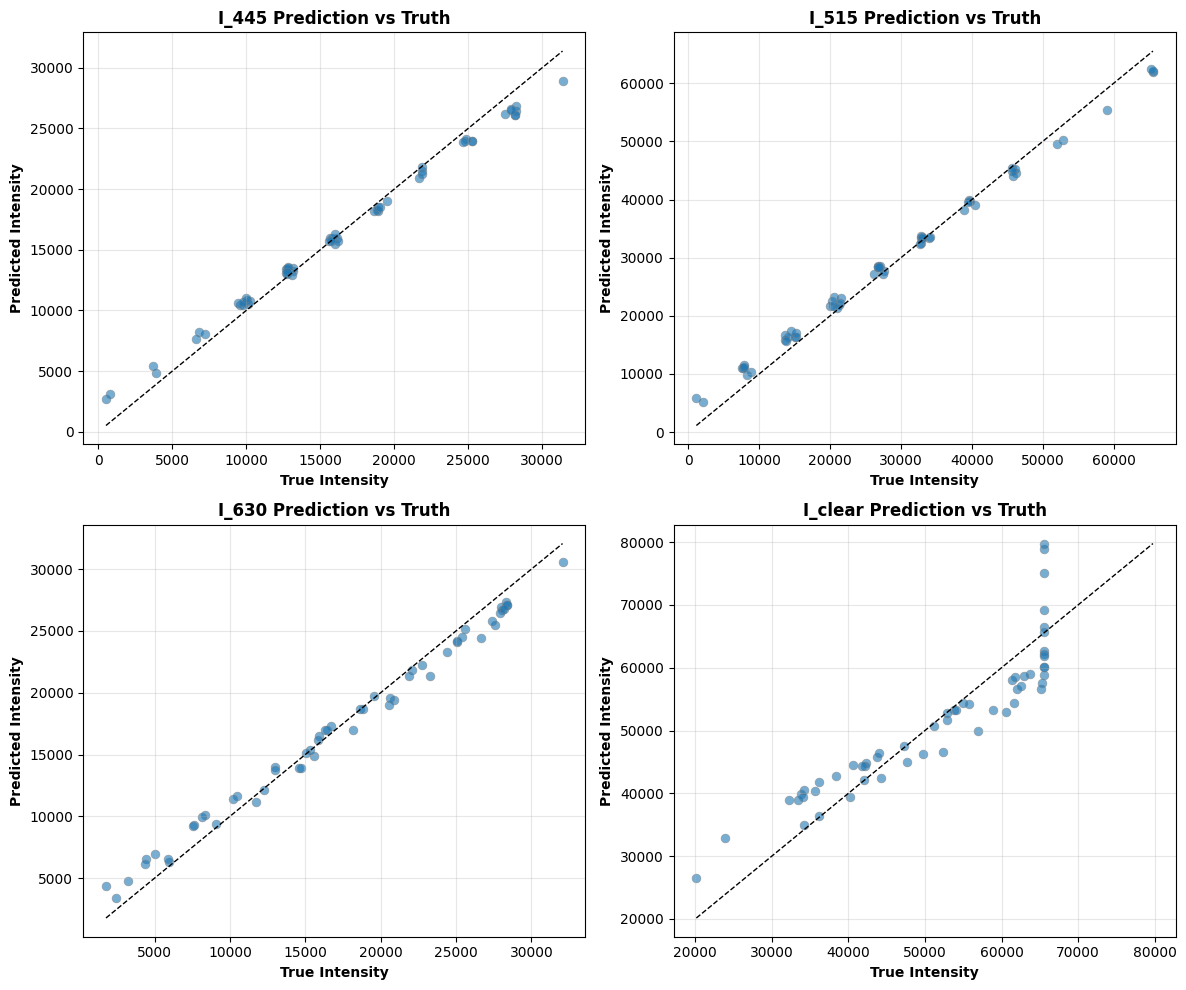

In [30]:
import matplotlib.pyplot as plt
import numpy as np

true_cols = ['I_445', 'I_515', 'I_630', 'I_clear']

# Ensure arrays are numpy arrays
Y_eval_orig = np.array(Y_eval_orig)
Y_pred_after = np.array(Y_pred_after)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(true_cols):
    ax = axes[i]
    ax.scatter(
        Y_eval_orig[:, i],
        Y_pred_after[:, i],
        alpha=0.6,
        edgecolor='gray',
        linewidth=0.5,
        s=40
    )

    # Parity line
    min_val = min(Y_eval_orig[:, i].min(), Y_pred_after[:, i].min())
    max_val = max(Y_eval_orig[:, i].max(), Y_pred_after[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    # Labels and titles
    ax.set_title(f"{col} Prediction vs Truth", fontsize=12, fontweight='bold')
    ax.set_xlabel("True Intensity", fontsize=10, fontweight='bold')
    ax.set_ylabel("Predicted Intensity", fontsize=10, fontweight='bold')

    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
